<a href="https://colab.research.google.com/github/Sohaib9920/Transformer_Text_Classification/blob/main/Transformer_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Task: Classify emotions in the twitter messages.**

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00


In [2]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.4 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=064db38c0702ae6e99553b1f599af3641b6f97e2d2745cb04a46be19476e56f4
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [55]:
from datasets import load_dataset, load_from_disk
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

# Loading Data

In [4]:
emotions = load_dataset("emotion")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_ds = emotions["train"]
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}



---


Or If data is available remote or locally then:

In [7]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
!wget {dataset_url}

--2024-01-25 16:37:01--  https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt
Resolving huggingface.co (huggingface.co)... 18.155.173.64, 18.155.173.45, 18.155.173.122, ...
Connecting to huggingface.co (huggingface.co)|18.155.173.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1658616 (1.6M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   1.58M  9.25MB/s    in 0.2s    

2024-01-25 16:37:02 (9.25 MB/s) - ‘train.txt’ saved [1658616/1658616]



In [8]:
!head "train.txt"

i didnt feel humiliated;sadness
i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake;sadness
im grabbing a minute to post i feel greedy wrong;anger
i am ever feeling nostalgic about the fireplace i will know that it is still on the property;love
i am feeling grouchy;anger
ive been feeling a little burdened lately wasnt sure why that was;sadness
ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny;surprise
i feel as confused about life as a teenager or as jaded as a year old man;fear
i have been with petronas for years i feel that petronas has performed well and made a huge profit;joy
i feel romantic too;love


In [9]:
emotions_local = load_dataset("csv", data_files="train.txt", sep=",", names=["text", "label"])

Generating train split: 0 examples [00:00, ? examples/s]

In [10]:
emotions_local

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
})

OR

In [11]:
emotions_local = load_dataset("csv", data_files=dataset_url, sep=",", names=["text", "label"], split=["train[:80%]", "train[80%:90%]", "train[90%:]"])

Generating train split: 0 examples [00:00, ? examples/s]

In [12]:
emotions_local

[Dataset({
     features: ['text', 'label'],
     num_rows: 12800
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1600
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1600
 })]



---



# Visualizing the data

In [13]:
emotions.set_format(type="pandas") # Only change the output fromat and not the underlying data format (Arrow Table)
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [14]:
class_labels = emotions["train"].features["label"]
class_labels

ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)

In [15]:
df["label_name"] = df["label"].apply(lambda x: class_labels.int2str(x))
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


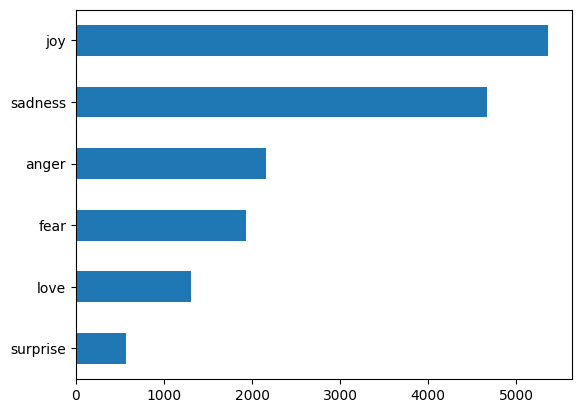

In [16]:
df["label_name"].value_counts(ascending=True).plot.barh();

Transformer models have a maximum input sequence length that is referred to as the
maximum context size. **For applications using DistilBERT, the maximum context size is 512 tokens**. Lets get an estimate of how long are our tweets

In [17]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.head()

,text,label,label_name,Words Per Tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


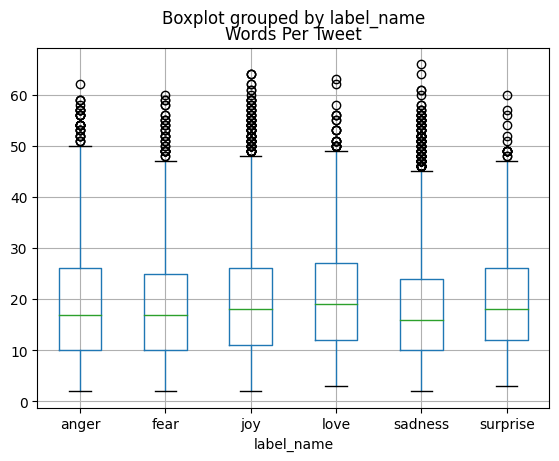

In [18]:
df.boxplot("Words Per Tweet", by="label_name");

Maximum words per tweet are less than the maximum context size of 512. Most of the tweets are about 15 words longs, for all emotions.

In [19]:
emotions.reset_format()

# Tokenization

In [20]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [21]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [22]:
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [23]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [24]:
tokenizer.convert_tokens_to_string(tokens) # similar to " ".join() but handle sub-word tokenization artifacts

'[CLS] tokenizing text is a core task of nlp. [SEP]'

In [25]:
tokenizer.vocab_size, tokenizer.model_max_length, tokenizer.model_input_names

(30522, 512, ['input_ids', 'attention_mask'])

Tokenizing whole dataset:

In [26]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [27]:
tokenize(emotions["train"][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

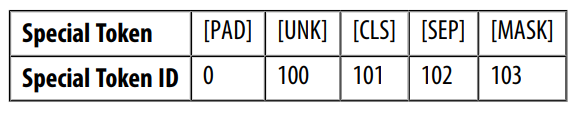

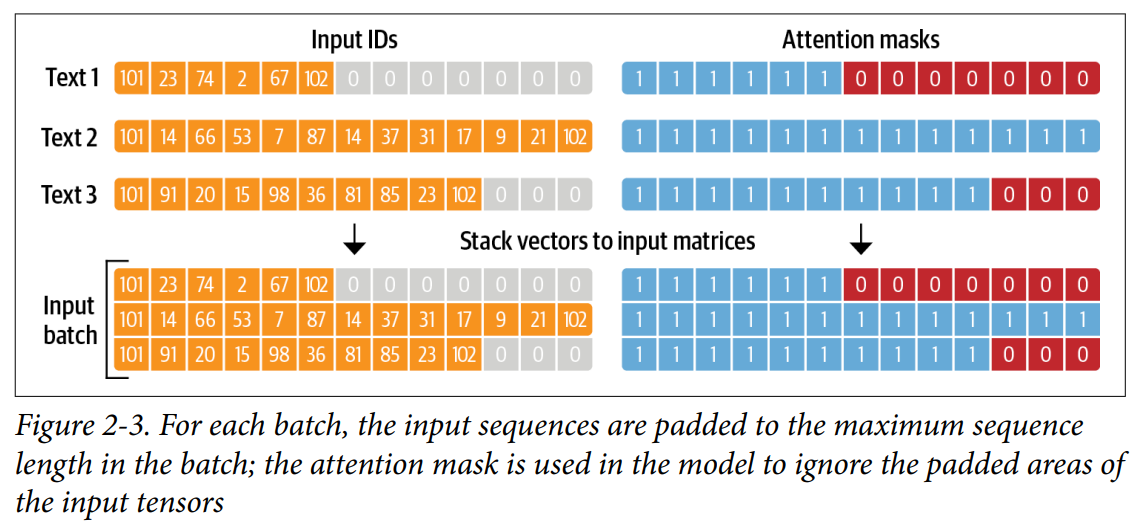

In [28]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

By default, the `map()` method operates individually on every example in the corpus,
so setting `batched=True` will encode the tweets in batches. Because we’ve set
`batch_size=None`, our `tokenize()` function will be applied on the full dataset as a
single batch. This ensures that the input tensors and attention masks have the same
shape globally

In [29]:
emotions_encoded.column_names

{'train': ['text', 'label', 'input_ids', 'attention_mask'],
 'validation': ['text', 'label', 'input_ids', 'attention_mask'],
 'test': ['text', 'label', 'input_ids', 'attention_mask']}

In [30]:
import pandas as pd
pd.DataFrame(emotions_encoded["train"][:5])

,text,label,input_ids,attention_mask
0,i didnt feel humiliated,0,"[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,i can go from feeling so hopeless to so damned...,0,"[101, 1045, 2064, 2175, 2013, 3110, 2061, 2062...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,im grabbing a minute to post i feel greedy wrong,3,"[101, 10047, 9775, 1037, 3371, 2000, 2695, 104...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
3,i am ever feeling nostalgic about the fireplac...,2,"[101, 1045, 2572, 2412, 3110, 16839, 9080, 128...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,i am feeling grouchy,3,"[101, 1045, 2572, 3110, 24665, 7140, 11714, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."


# Training a Text Classifier

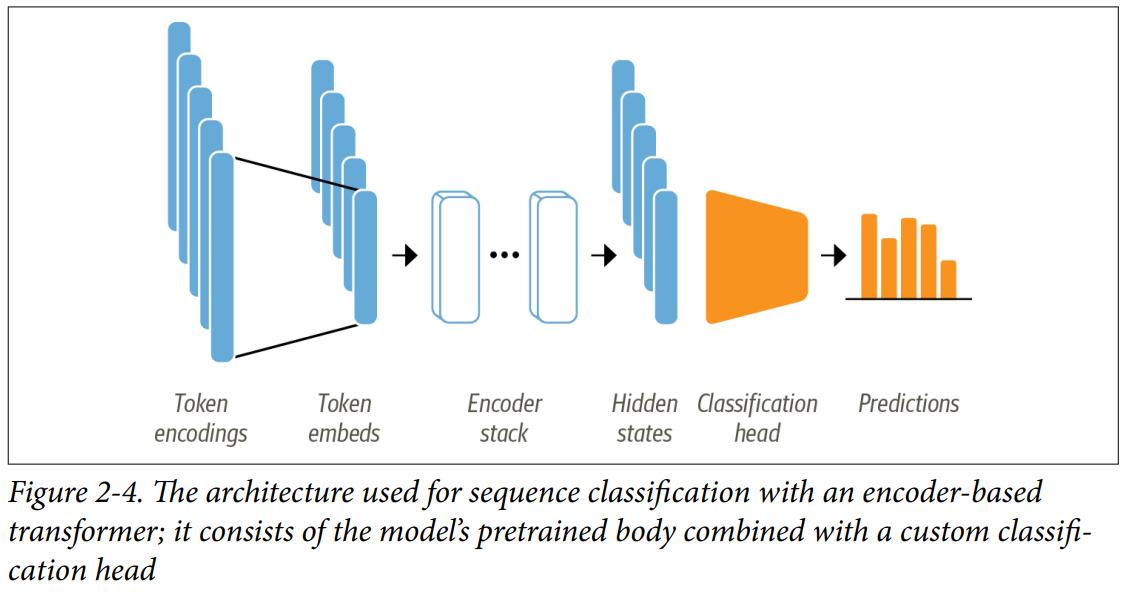

- First, the text is tokenized and represented as one-hot vectors called token encodings.
The size of the tokenizer vocabulary determines the dimension of the token encodings, and it usually consists of 20k–200k unique tokens.

  - In practice, PyTorch (and tf) skips the step of creating one-hot vectors for
token encodings because multiplying a matrix with a one-hot vector is the same as selecting a column (or row in tf) from the matrix. This can be
done directly by getting the column (or row in tf) with the token ID from the
matrix.

- The token embeddings are then passed through the encoder block layers to
yield a hidden state for each input token. For the pretraining objective of language
modeling, each hidden state is fed to a layer that predicts the masked input tokens.
For the classification task, we replace the language modeling layer with a classification layer.

We have two options to train such a model on our Twitter dataset:

1. *Feature extraction*

  We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.

2. *Fine-tuning*

  We train the whole model end-to-end, which also updates the parameters of the
pretrained model.


## Transformers as Feature Extractors

The advantage of this approach is that we can quickly train a small or shallow model. Such a model could be a neural classification layer or a method that does
not rely on gradients, such as a random forest. This method is especially convenient if
GPUs are unavailable, since the hidden states only need to be precomputed once.

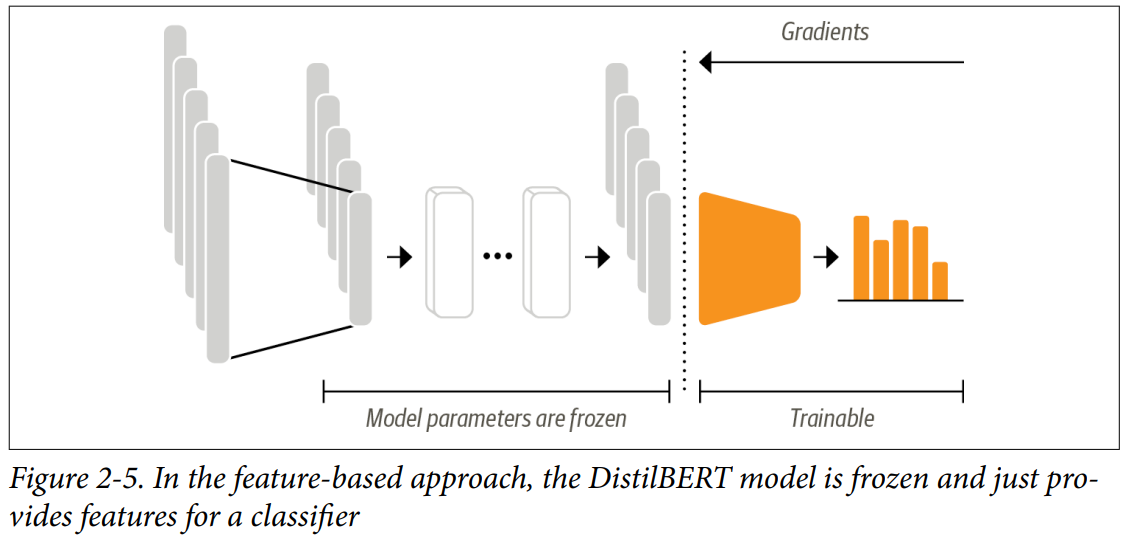

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [32]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

### Extracting last hidden states

In [33]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt").to(device)

In [34]:
inputs, inputs.input_ids.shape

({'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='cuda:0')},
 torch.Size([1, 6]))

As we can see, the resulting tensor has the shape [batch_size, n_tokens]

In [35]:
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

In [36]:
outputs

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)

In [37]:
outputs.last_hidden_state.shape

torch.Size([1, 6, 768])

Looking at the hidden state tensor, we see that it has the shape [batch_size,
n_tokens, hidden_dim]. In other words, a 768-dimensional vector is returned for
each of the 6 input tokens.

For classification tasks, it is common practice to just use
the hidden state associated with the [CLS] token as the input feature.

Why? Because in BERT, each token gives attention to all the non-pad tokens (self-attention), which improves the contextual representation of each token. It keeps getting better with each MultiHeadSelfAttention block. Now goal is to predict the masked token. Other tokens predict the same token. The [CLS] token, which has representation of all the tokens in sentence, is used for classification.

[CLS] Sentence 1 [SEP] --> [CLS] Classify the Sentence 1

[CLS] Sentence 1 [SEP] Sentence 2 [SEP] --> [CLS] Classify Sentence 1 and Sentence 2 i.e Next sequence prediction (NSP)

In [38]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [39]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# Set __getitem__ return format (type and columns). The format is set for every dataset in the dataset dictionary.
emotions_encoded["train"][:]

{'label': tensor([0, 0, 3,  ..., 1, 3, 0]),
 'input_ids': tensor([[  101,  1045,  2134,  ...,     0,     0,     0],
         [  101,  1045,  2064,  ...,     0,     0,     0],
         [  101, 10047,  9775,  ...,     0,     0,     0],
         ...,
         [  101,  1045,  2514,  ...,     0,     0,     0],
         [  101,  1045,  2514,  ...,     0,     0,     0],
         [  101,  1045,  2113,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

In [40]:
emotions_encoded["train"]["input_ids"].shape

torch.Size([16000, 87])

In [41]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [42]:
def get_hidden_state(batch):
    inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()} # Only [CLS] hidden state

We place the final hidden state back on the CPU as a NumPy array. The map()
method requires the processing function to return Python or NumPy objects when
we’re using batched inputs.

In [43]:
emotions_hidden = emotions_encoded.map(get_hidden_state, batched=True) # default batch_size=1000 is used

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [44]:
emotions_hidden.column_names

{'train': ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
 'validation': ['text',
  'label',
  'input_ids',
  'attention_mask',
  'hidden_state'],
 'test': ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']}

In [45]:
emotions_hidden["train"][:]

{'label': tensor([0, 0, 3,  ..., 1, 3, 0]),
 'input_ids': tensor([[  101,  1045,  2134,  ...,     0,     0,     0],
         [  101,  1045,  2064,  ...,     0,     0,     0],
         [  101, 10047,  9775,  ...,     0,     0,     0],
         ...,
         [  101,  1045,  2514,  ...,     0,     0,     0],
         [  101,  1045,  2514,  ...,     0,     0,     0],
         [  101,  1045,  2113,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'hidden_state': tensor([[-0.1168,  0.0986, -0.1296,  ...,  0.0587,  0.3543,  0.4042],
         [-0.0324, -0.0323, -0.1957,  ..., -0.1747,  0.3546,  0.3028],
         [ 0.0397,  0.2022,  0.1423,  ..., -0.1141,  0.3394,  0.3958],
         ...,
         [-0.0034, -0.0959,  0.0584,  ..., -0.0427,  0.2496,  0.3076],
         [ 0.06

Notice that `map()` add new column as list/numpy and it is automatically included in the columns of output format which is tensor

In [46]:
emotions_hidden["train"]["hidden_state"].shape

torch.Size([16000, 768])

### Saving and loadin Dataset

In [53]:
dir = "./emotions_hidden"
emotions_hidden.save_to_disk(dir)
!tar czf emotions_hidden.tar.gz {dir}

Saving the dataset (0/1 shards):   0%|          | 0/16000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
!tar xzf emotions_hidden.tar.gz
emotions_hidden = load_from_disk("./emotions_hidden")

In [7]:
# In case you are restarting session and want to continue...
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Now that we have the hidden states associated with each tweet, the next step is to
train a classifier on them. To do that, we’ll need a feature matrix—let’s take a look.

### Creating a feature matrix

In [8]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

Before we train a model on the hidden states, it’s good practice to perform a quick
check to ensure that they provide a useful representation of the emotions we want to classify.

### Visualizing the training set

Since visualizing the hidden states in 768 dimensions is tricky to say the least, we’ll
use the powerful UMAP algorithm to project the vectors down to 2D.
 Since UMAP
works best when the features are scaled to lie in the [0,1] interval, we’ll first apply a
MinMaxScaler and then use the UMAP implementation from the umap-learn library
to reduce the hidden states:


In [15]:
X_scaled = MinMaxScaler().fit_transform(X_train)
reducer = UMAP(n_components=2, metric="cosine").fit(X_scaled)
df_emb = pd.DataFrame(reducer.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.055415,6.472508,0
1,-3.334085,5.682221,0
2,5.433984,3.119511,3
3,-2.471373,3.229601,2
4,-3.391268,3.680594,3


In [14]:
labels = emotions_hidden["train"].features["label"].names
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

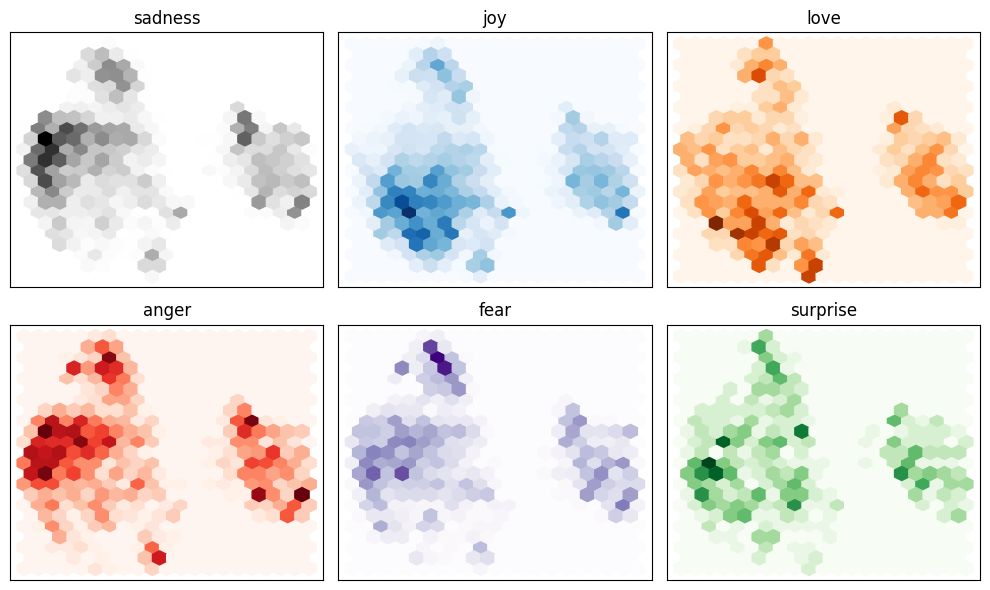

In [45]:
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
plt.figure(figsize=(10,6))
for i, label in enumerate(labels):
    plt.subplot(2, 3, i+1)
    df_emb_sub = df_emb.query(f"label == {i}")
    plt.hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmaps[i], gridsize=20)
    plt.title(label)
    plt.xticks([]); plt.yticks([])
plt.tight_layout()

>note: These are only projections onto a lower-dimensional space. Just because some categories overlap does not mean that they are not separable in the original space. Conversely, if they are separable in the projected space they will be separable in the original space.

From this plot we can see some clear patterns: the negative feelings such as `sadness`, `anger`, and `fear` all occupy similar regions with slightly varying distributions. On the other hand, `joy` and `love` are well separated from the negative emotions and also share a similar space. Finally, `surprise` is scattered all over the place.

*Although we may have hoped for some separation, this is in no way guaranteed since the model was not trained to know the difference between these emotions. It only learned them implicitly by guessing the masked words in texts.*

Now that we've gained some insight into the features of our dataset, let's finally train a model on it!

### Training a simple Classifier

We've seen that the hidden states are somewhat different between the emotions, although for several of them there is no obvious boundary. Let's use these hidden states to train a logistic regression model with Scikit-Learn.

In [53]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

We can examine whether our model is any good by comparing it
against a simple baseline.

In [54]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

So, our simple classifier with DistilBERT embeddings is significantly better than our
baseline.

In [59]:
y_valid

array([0, 0, 2, ..., 1, 1, 1])

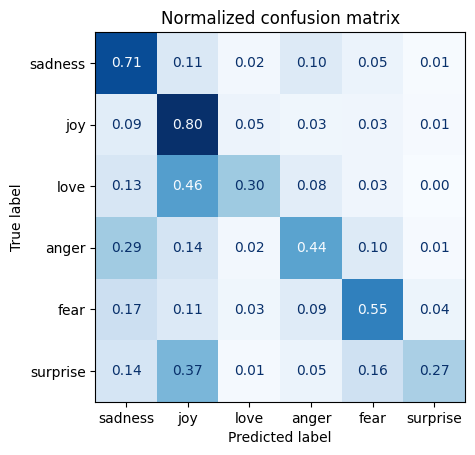

In [67]:
ConfusionMatrixDisplay.from_estimator(lr_clf, X_valid, y_valid,
                                      display_labels=labels, values_format=".2f",
                                      normalize="true", cmap="Blues", colorbar=False)
plt.title("Normalized confusion matrix");